<a href="https://colab.research.google.com/github/bugrakaann/SuspiciousActionRecognition/blob/master/x3dxs_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install pytorchvideo torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:

In [8]:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
import gdown
import zipfile

file_id = '1TNnf9zzoreiF7qaWZFjRXEDejThIbXJe'
url = f"https://drive.google.com/uc?export=download&confirm=t&id={file_id}"

# Dosyayı indir
output_path = '/content/sample_data/dataset.zip'
gdown.download(url, output_path, quiet=False)

# Dosyayı unzip yap
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

print("Dosya başarıyla indirildi ve çıkarıldı.")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=t&id=1TNnf9zzoreiF7qaWZFjRXEDejThIbXJe
To: /content/sample_data/dataset.zip
100%|██████████| 10.3G/10.3G [02:12<00:00, 78.1MB/s]


Dosya başarıyla indirildi ve çıkarıldı.


In [9]:
import os
import pandas as pd

# 🔥 Ana dataset klasörü
dataset_path = "/content/sample_data/dataset/Videos/Videos/"

# 📌 Normal ve Abnormal klasörlerini al
normal_path = os.path.normpath(os.path.join(dataset_path, "normal"))
abnormal_path = os.path.normpath(os.path.join(dataset_path, "abnormal"))

# 📌 Tüm abnormal sınıfları al
abnormal_classes = [folder for folder in os.listdir(abnormal_path) if os.path.isdir(os.path.join(abnormal_path, folder))]
class_to_index = {cls: idx for idx, cls in enumerate(abnormal_classes, start=1)}  # 1, 2, 3... (Abnormal sınıflar)

# 📌 DataFrame oluşturmak için liste
data = []

# ✅ Normal videolar (Binary = 0, Multi = -1)
for subfolder in os.listdir(normal_path):
    subfolder_path = os.path.normpath(os.path.join(normal_path, subfolder))

    if os.path.isdir(subfolder_path):  # Eğer bir klasörse
        videos = [
            os.path.normpath(os.path.join(subfolder_path, v)).replace("\\", "/")  # Windows uyumu için düzeltilmiş
            for v in os.listdir(subfolder_path) if v.endswith(('.mp4', '.avi', '.mov'))
        ]
        for video in videos:
            data.append((video, "normal", 0, -1))  # Binary label = 0, Multi label = -1 (yok)

# ✅ Anormal videolar (Binary = 1, Multi = class index)
for subfolder in abnormal_classes:
    subfolder_path = os.path.normpath(os.path.join(abnormal_path, subfolder))

    if os.path.isdir(subfolder_path):
        # Rekürsif olarak tüm alt klasörleri gezer
        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith(('.mp4', '.avi', '.mov')):
                    video_path = os.path.normpath(os.path.join(root, file)).replace("\\", "/")
                    # Burada 'subfolder' en üst düzey klasör adını temsil eder;
                    # eğer alt klasörlere göre farklı etiket atamak isterseniz, root veya dosya adını parse edebilirsiniz.
                    data.append((video_path, subfolder, 1, class_to_index.get(subfolder, -1)))

# 🔥 DataFrame oluştur
df = pd.DataFrame(data, columns=["video_path", "category", "binary_label", "multi_label"])


In [10]:
train_df, test_df = train_test_split(df, test_size=0.2,stratify=df["binary_label"],random_state=42)

print(f"Train set {len(train_df)} videos")
print(f"Test set {len(test_df)} videos")

Train set 2603 videos
Test set 651 videos


In [5]:
import tensorflow as tf

# GPU kullanımını kontrol et
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU bulunuyor:", physical_devices)
else:
    print("GPU bulunamadı.")


GPU bulunuyor: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


GPU için bellek büyüme modu etkinleştirildi.
TensorFlow CUDA destekli mi?: True
Fiziksel GPU var mı?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Normal videolardan frame'ler yükleniyor...


NTU_fight0027_sit_1.mp4: 2 kare yüklendi.


NTU_fight0030_sit_1.mp4: 4 kare yüklendi.


NTU_fight0042_sit_1.mp4: 6 kare yüklendi.


NTU_fight0054_sit_1.mp4: 4 kare yüklendi.


NTU_fight0054_sit_2.mp4: 4 kare yüklendi.


NTU_fight0067_sit_1.mp4: 4 kare yüklendi.


NTU_fight0097_sit_1.mp4: 3 kare yüklendi.


NTU_fight0098_sit_1.mp4: 4 kare yüklendi.


NTU_fight0098_sit_2.mp4: 4 kare yüklendi.


NTU_fight0115_sit_1.mp4: 3 kare yüklendi.


NTU_fight0121_sit_1.mp4: 3 kare yüklendi.


NTU_fight0122_sit_1.mp4: 3 kare yüklendi.


NTU_fight0133_sit_1.mp4: 3 kare yüklendi.


NTU_fight0146_sit_1.mp4: 2 kare yüklendi.


NTU_fight0162_sit_1.mp4: 4 kare yüklendi.


NTU_fight0188_sit_1.mp4: 4 kare yüklendi.


NTU_fight0200_sit_1.mp4: 4 kare yüklendi.


NTU_fight0223_sit_1.mp4: 4 kare yüklendi.


NTU_fight0226_sit_1.mp4: 6 kare yüklendi.


NTU_fight0228_sit_1.mp4: 5 kare yüklendi.


NTU_fight0242_sit_1.mp4: 5 kare yüklendi.


NTU_fight0244_sit_1.mp4: 3 kare yüklendi.


NTU_fight0246_sit_1.mp4: 5 kare yüklendi.


NTU_fight0321_sit_1.mp4: 1 kare yüklendi.


NTU_fight0599_sit_1.mp4: 5 kare yüklendi.


NTU_fight0990_sit_1.mp4: 5 kare yüklendi.


NTU_fight0994_sit_1.mp4: 4 kare yüklendi.


NTU_fight0995_sit_1.mp4: 1 kare yüklendi.


UCFCRIME_Abuse040_sit_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson016_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson029_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault004_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault009_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault010_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault010_sit_2.mp4: 3 kare yüklendi.


UCFCRIME_Burglary064_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Burglary064_sit_2.mp4: 8 kare yüklendi.


UCFCRIME_Fighting046_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Fighting049_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Fighting049_sit_2.mp4: 4 kare yüklendi.


UCFCRIME_Robbery019_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery020_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery024_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery026_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery037_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery045_sit_1.mp4: 6 kare yüklendi.


UCFCRIME_Robbery062_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery073_sit_1.mp4: 6 kare yüklendi.


UCFCRIME_Robbery080_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery090_sit_1.mp4: 2 kare yüklendi.


UCFCRIME_Robbery093_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery093_sit_2.mp4: 2 kare yüklendi.


UCFCRIME_Robbery097_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery123_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery126_sit_1.mp4: 1 kare yüklendi.


UCFCRIME_Robbery127_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery144_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery146_sit_1.mp4: 1 kare yüklendi.


UCFCRIME_Shooting006_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting017_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting022_sit_1.mp4: 6 kare yüklendi.


UCFCRIME_Shooting030_sit_1.mp4: 2 kare yüklendi.


UCFCRIME_Shooting031_sit_1.mp4: 2 kare yüklendi.


UCFCRIME_Shooting048_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting003_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting007_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting008_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting010_sit_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting012_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting012_sit_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting024_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting037_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting038_sit_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting043_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting044_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting051_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing009_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing011_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing022_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing024_sit_1.mp4: 1 kare yüklendi.


UCFCRIME_Stealing024_sit_2.mp4: 2 kare yüklendi.


UCFCRIME_Stealing025_sit_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing036_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing042_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing044_sit_1.mp4: 6 kare yüklendi.


UCFCRIME_Stealing057_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing057_sit_2.mp4: 3 kare yüklendi.


UCFCRIME_Stealing057_sit_3.mp4: 2 kare yüklendi.


UCFCRIME_Stealing083_sit_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing096_sit_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing104_sit_1.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_1.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_10.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_11.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_12.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_13.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_2.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_3.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_4.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_5.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_6.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_7.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_8.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV001_sit_9.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV002_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV002_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV002_sit_3.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV002_sit_4.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV004_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV005_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV008_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_1.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_3.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_4.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_5.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_6.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV010_sit_7.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV012_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV014_sit_1.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV014_sit_2.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV014_sit_3.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV014_sit_4.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV014_sit_5.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV015_sit_1.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV015_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV015_sit_3.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV015_sit_4.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV015_sit_5.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_2.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_3.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_4.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_5.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_6.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_7.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV017_sit_8.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV019_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV020_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV021_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV022_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV022_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV022_sit_3.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV030_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV036_sit_1.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV036_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV036_sit_3.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV042_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV042_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV042_sit_3.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV044_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV044_sit_2.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_2.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_3.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_4.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_5.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_6.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_7.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_8.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV045_sit_9.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV049_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV053_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV053_sit_2.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_10.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_2.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_3.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_4.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_5.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_6.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_7.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_8.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV057_sit_9.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV061_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV073_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV076_sit_1.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV078_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV078_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV081_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV081_sit_2.mp4: 2 kare yüklendi.


YOUTUBE_YouTubeCCTV084_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV086_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV086_sit_2.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV086_sit_3.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV086_sit_4.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV091_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV091_sit_2.mp4: 5 kare yüklendi.


YOUTUBE_YouTubeCCTV096_sit_1.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV097_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV097_sit_2.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV097_sit_3.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV098_sit_1.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV099_sit_1.mp4: 1 kare yüklendi.


YOUTUBE_YouTubeCCTV100_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV100_sit_2.mp4: 4 kare yüklendi.


YOUTUBE_YouTubeCCTV100_sit_3.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV101_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV102_sit_1.mp4: 3 kare yüklendi.


YOUTUBE_YouTubeCCTV102_sit_2.mp4: 3 kare yüklendi.


n001_converted.avi: 5 kare yüklendi.


n002_converted.avi: 5 kare yüklendi.


n003_converted.avi: 4 kare yüklendi.


n004_converted.avi: 5 kare yüklendi.


n005_converted.avi: 5 kare yüklendi.


n006_converted.avi: 5 kare yüklendi.


n007_converted.avi: 4 kare yüklendi.


n008_converted.avi: 4 kare yüklendi.


n009_converted.avi: 4 kare yüklendi.


n010_converted.avi: 4 kare yüklendi.


n011_converted.avi: 4 kare yüklendi.


n012_converted.avi: 5 kare yüklendi.


n013_converted.avi: 4 kare yüklendi.


n014_converted.avi: 4 kare yüklendi.


n015_converted.avi: 4 kare yüklendi.


n016_converted.avi: 4 kare yüklendi.


n017_converted.avi: 4 kare yüklendi.


n018_converted.avi: 4 kare yüklendi.


n019_converted.avi: 4 kare yüklendi.


n020_converted.avi: 4 kare yüklendi.


n021_converted.avi: 4 kare yüklendi.


n022_converted.avi: 4 kare yüklendi.


n023_converted.avi: 4 kare yüklendi.


n024_converted.avi: 4 kare yüklendi.


n025_converted.avi: 3 kare yüklendi.


n026_converted.avi: 3 kare yüklendi.


n027_converted.avi: 3 kare yüklendi.


n028_converted.avi: 4 kare yüklendi.


n029_converted.avi: 5 kare yüklendi.


n030_converted.avi: 5 kare yüklendi.


n031_converted.avi: 4 kare yüklendi.


n032_converted.avi: 4 kare yüklendi.


n033_converted.avi: 5 kare yüklendi.


n034_converted.avi: 5 kare yüklendi.


n035_converted.avi: 6 kare yüklendi.


n036_converted.avi: 4 kare yüklendi.


n037_converted.avi: 5 kare yüklendi.


n038_converted.avi: 5 kare yüklendi.


n039_converted.avi: 4 kare yüklendi.


n040_converted.avi: 5 kare yüklendi.


n041_converted.avi: 5 kare yüklendi.


n042_converted.avi: 5 kare yüklendi.


n043_converted.avi: 5 kare yüklendi.


n044_converted.avi: 4 kare yüklendi.


n045_converted.avi: 5 kare yüklendi.


n046_converted.avi: 4 kare yüklendi.


n047_converted.avi: 5 kare yüklendi.


n048_converted.avi: 5 kare yüklendi.


n049_converted.avi: 5 kare yüklendi.


n050_converted.avi: 5 kare yüklendi.


n051_converted.avi: 4 kare yüklendi.


n052_converted.avi: 4 kare yüklendi.


n053_converted.avi: 5 kare yüklendi.


n054_converted.avi: 4 kare yüklendi.


n055_converted.avi: 4 kare yüklendi.


n056_converted.avi: 3 kare yüklendi.


n057_converted.avi: 4 kare yüklendi.


n058_converted.avi: 4 kare yüklendi.


n059_converted.avi: 4 kare yüklendi.


n060_converted.avi: 4 kare yüklendi.


n061_converted.avi: 4 kare yüklendi.


n062_converted.avi: 4 kare yüklendi.


n063_converted.avi: 3 kare yüklendi.


n064_converted.avi: 5 kare yüklendi.


n065_converted.avi: 5 kare yüklendi.


n066_converted.avi: 5 kare yüklendi.


n067_converted.avi: 6 kare yüklendi.


n068_converted.avi: 5 kare yüklendi.


n069_converted.avi: 4 kare yüklendi.


n070_converted.avi: 4 kare yüklendi.


n071_converted.avi: 4 kare yüklendi.


n072_converted.avi: 4 kare yüklendi.


n073_converted.avi: 4 kare yüklendi.


n074_converted.avi: 4 kare yüklendi.


n075_converted.avi: 4 kare yüklendi.


n076_converted.avi: 3 kare yüklendi.


n077_converted.avi: 4 kare yüklendi.


n078_converted.avi: 4 kare yüklendi.


n079_converted.avi: 4 kare yüklendi.


n080_converted.avi: 4 kare yüklendi.


n081_converted.avi: 3 kare yüklendi.


n082_converted.avi: 4 kare yüklendi.


n083_converted.avi: 4 kare yüklendi.


n084_converted.avi: 3 kare yüklendi.


n085_converted.avi: 3 kare yüklendi.


n086_converted.avi: 5 kare yüklendi.


n087_converted.avi: 4 kare yüklendi.


n088_converted.avi: 4 kare yüklendi.


n089_converted.avi: 5 kare yüklendi.


n090_converted.avi: 4 kare yüklendi.


n091_converted.avi: 4 kare yüklendi.


n092_converted.avi: 4 kare yüklendi.


n093_converted.avi: 4 kare yüklendi.


n094_converted.avi: 3 kare yüklendi.


n095_converted.avi: 3 kare yüklendi.


n096_converted.avi: 3 kare yüklendi.


n097_converted.avi: 4 kare yüklendi.


n098_converted.avi: 3 kare yüklendi.


n099_converted.avi: 5 kare yüklendi.


n100_converted.avi: 5 kare yüklendi.


n101_converted.avi: 5 kare yüklendi.


n102_converted.avi: 4 kare yüklendi.


n103_converted.avi: 4 kare yüklendi.


n104_converted.avi: 4 kare yüklendi.


n105_converted.avi: 4 kare yüklendi.


n106_converted.avi: 4 kare yüklendi.


n107_converted.avi: 4 kare yüklendi.


n108_converted.avi: 5 kare yüklendi.


n109_converted.avi: 4 kare yüklendi.


n110_converted.avi: 5 kare yüklendi.


n111_converted.avi: 3 kare yüklendi.


n112_converted.avi: 3 kare yüklendi.


n113_converted.avi: 9 kare yüklendi.


n114_converted.avi: 8 kare yüklendi.


n115_converted.avi: 8 kare yüklendi.


n116_converted.avi: 4 kare yüklendi.


n117_converted.avi: 3 kare yüklendi.


n118_converted.avi: 4 kare yüklendi.


n119_converted.avi: 4 kare yüklendi.


n120_converted.avi: 3 kare yüklendi.


n121_converted.avi: 4 kare yüklendi.


n122_converted.avi: 3 kare yüklendi.


n123_converted.avi: 4 kare yüklendi.


n124_converted.avi: 3 kare yüklendi.


n125_converted.avi: 4 kare yüklendi.


n126_converted.avi: 4 kare yüklendi.


n127_converted.avi: 4 kare yüklendi.


n128_converted.avi: 4 kare yüklendi.


n129_converted.avi: 4 kare yüklendi.


n130_converted.avi: 4 kare yüklendi.


n131_converted.avi: 5 kare yüklendi.


n132_converted.avi: 5 kare yüklendi.


n133_converted.avi: 4 kare yüklendi.


n134_converted.avi: 5 kare yüklendi.


n135_converted.avi: 4 kare yüklendi.


n136_converted.avi: 4 kare yüklendi.


n137_converted.avi: 3 kare yüklendi.


n138_converted.avi: 4 kare yüklendi.


n139_converted.avi: 3 kare yüklendi.


n140_converted.avi: 4 kare yüklendi.


n141_converted.avi: 4 kare yüklendi.


n142_converted.avi: 4 kare yüklendi.


n143_converted.avi: 1 kare yüklendi.


n144_converted.avi: 1 kare yüklendi.


n145_converted.avi: 0 kare yüklendi.


n146_converted.avi: 1 kare yüklendi.


n147_converted.avi: 1 kare yüklendi.


n148_converted.avi: 0 kare yüklendi.


n149_converted.avi: 0 kare yüklendi.


n150_converted.avi: 1 kare yüklendi.


n151_converted.avi: 0 kare yüklendi.


n152_converted.avi: 0 kare yüklendi.


n153_converted.avi: 1 kare yüklendi.


n154_converted.avi: 1 kare yüklendi.


n155_converted.avi: 1 kare yüklendi.


n156_converted.avi: 4 kare yüklendi.


n157_converted.avi: 3 kare yüklendi.


n158_converted.avi: 3 kare yüklendi.


n159_converted.avi: 3 kare yüklendi.


n160_converted.avi: 3 kare yüklendi.


n161_converted.avi: 5 kare yüklendi.


n162_converted.avi: 3 kare yüklendi.


n163_converted.avi: 3 kare yüklendi.


n164_converted.avi: 3 kare yüklendi.


n165_converted.avi: 4 kare yüklendi.


n166_converted.avi: 2 kare yüklendi.


n167_converted.avi: 1 kare yüklendi.


n168_converted.avi: 1 kare yüklendi.


n169_converted.avi: 1 kare yüklendi.


n170_converted.avi: 1 kare yüklendi.


n171_converted.avi: 1 kare yüklendi.


n172_converted.avi: 0 kare yüklendi.


n173_converted.avi: 0 kare yüklendi.


n174_converted.avi: 1 kare yüklendi.


n175_converted.avi: 1 kare yüklendi.


n176_converted.avi: 0 kare yüklendi.


n177_converted.avi: 1 kare yüklendi.


n178_converted.avi: 1 kare yüklendi.


n179_converted.avi: 1 kare yüklendi.


n180_converted.avi: 0 kare yüklendi.


n181_converted.avi: 0 kare yüklendi.


n182_converted.avi: 0 kare yüklendi.


n183_converted.avi: 1 kare yüklendi.


n184_converted.avi: 0 kare yüklendi.


n185_converted.avi: 1 kare yüklendi.


n186_converted.avi: 1 kare yüklendi.


n187_converted.avi: 1 kare yüklendi.


n188_converted.avi: 1 kare yüklendi.


n189_converted.avi: 1 kare yüklendi.


n190_converted.avi: 4 kare yüklendi.


n191_converted.avi: 4 kare yüklendi.


n192_converted.avi: 4 kare yüklendi.


n193_converted.avi: 4 kare yüklendi.


n194_converted.avi: 3 kare yüklendi.


n195_converted.avi: 4 kare yüklendi.


n196_converted.avi: 4 kare yüklendi.


n197_converted.avi: 4 kare yüklendi.


n198_converted.avi: 4 kare yüklendi.


n199_converted.avi: 4 kare yüklendi.


n200_converted.avi: 4 kare yüklendi.


t_n001_converted.avi: 4 kare yüklendi.


t_n002_converted.avi: 4 kare yüklendi.


t_n003_converted.avi: 3 kare yüklendi.


t_n004_converted.avi: 4 kare yüklendi.


t_n005_converted.avi: 3 kare yüklendi.


t_n006_converted.avi: 4 kare yüklendi.


t_n007_converted.avi: 3 kare yüklendi.


t_n008_converted.avi: 3 kare yüklendi.


t_n009_converted.avi: 4 kare yüklendi.


t_n010_converted.avi: 4 kare yüklendi.


t_n011_converted.avi: 4 kare yüklendi.


t_n012_converted.avi: 4 kare yüklendi.


t_n013_converted.avi: 4 kare yüklendi.


t_n014_converted.avi: 4 kare yüklendi.


t_n015_converted.avi: 4 kare yüklendi.


t_n016_converted.avi: 2 kare yüklendi.


t_n017_converted.avi: 7 kare yüklendi.


t_n018_converted.avi: 4 kare yüklendi.


t_n019_converted.avi: 3 kare yüklendi.


t_n020_converted.avi: 3 kare yüklendi.


t_n021_converted.avi: 4 kare yüklendi.


t_n022_converted.avi: 4 kare yüklendi.


t_n023_converted.avi: 3 kare yüklendi.


t_n024_converted.avi: 4 kare yüklendi.


t_n025_converted.avi: 4 kare yüklendi.


t_n026_converted.avi: 4 kare yüklendi.


t_n027_converted.avi: 3 kare yüklendi.


t_n028_converted.avi: 4 kare yüklendi.


t_n029_converted.avi: 4 kare yüklendi.


t_n030_converted.avi: 3 kare yüklendi.


t_n031_converted.avi: 3 kare yüklendi.


t_n032_converted.avi: 4 kare yüklendi.


t_n033_converted.avi: 4 kare yüklendi.


t_n034_converted.avi: 4 kare yüklendi.


t_n035_converted.avi: 3 kare yüklendi.


t_n036_converted.avi: 3 kare yüklendi.


t_n037_converted.avi: 1 kare yüklendi.


t_n038_converted.avi: 4 kare yüklendi.


t_n039_converted.avi: 3 kare yüklendi.


t_n040_converted.avi: 4 kare yüklendi.


t_n041_converted.avi: 4 kare yüklendi.


t_n042_converted.avi: 4 kare yüklendi.


t_n043_converted.avi: 4 kare yüklendi.


t_n044_converted.avi: 4 kare yüklendi.


t_n045_converted.avi: 4 kare yüklendi.


t_n046_converted.avi: 4 kare yüklendi.


UCFCRIME_Abuse007_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Abuse007_walk_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse007_walk_3.mp4: 5 kare yüklendi.


UCFCRIME_Abuse014_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse014_walk_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse018_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse022_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Abuse028_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse028_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Abuse028_walk_3.mp4: 3 kare yüklendi.


UCFCRIME_Abuse029_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse030_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Abuse030_walk_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse031_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Abuse031_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Abuse034_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse046_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest001_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest001_walk_2.mp4: 2 kare yüklendi.


UCFCRIME_Arrest002_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest004_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest005_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest007_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest009_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest014_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest016_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest016_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Arrest016_walk_3.mp4: 4 kare yüklendi.


UCFCRIME_Arrest020_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Arrest022_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest022_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Arrest026_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest029_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest029_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Arrest029_walk_3.mp4: 3 kare yüklendi.


UCFCRIME_Arrest033_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest035_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest041_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest043_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest044_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest044_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Arrest046_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest047_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest048_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest049_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Arson001_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson001_walk_2.mp4: 2 kare yüklendi.


UCFCRIME_Arson002_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Arson006_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson007_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson007_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Arson014_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson015_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson017_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson017_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Arson020_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson027_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson028_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson034_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson044_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson047_walk_1.mp4: 1 kare yüklendi.


UCFCRIME_Arson052_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Assault010_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault010_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Assault011_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault011_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Assault014_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault016_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault016_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Assault034_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault040_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Assault047_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary005_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Burglary016_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Burglary020_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary025_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary031_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary039_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Burglary040_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Burglary040_walk_2.mp4: 5 kare yüklendi.


UCFCRIME_Burglary055_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Burglary062_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Burglary063_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Burglary066_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Burglary067_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Burglary073_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Burglary076_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Burglary092_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Fighting021_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Fighting027_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Fighting030_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Fighting031_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Fighting031_walk_2.mp4: 7 kare yüklendi.


UCFCRIME_Fighting041_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Fighting041_walk_2.mp4: 6 kare yüklendi.


UCFCRIME_Fighting043_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery009_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery021_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery027_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery032_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Robbery037_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery042_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery052_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery059_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery061_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery062_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery063_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery067_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Robbery069_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery069_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Robbery072_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery073_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery080_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery091_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery094_walk_1.mp4: 2 kare yüklendi.


UCFCRIME_Robbery095_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery096_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery097_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery099_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery103_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery106_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery112_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery119_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery119_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Robbery135_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery150_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shooting010_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting014_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shooting014_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Shooting022_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting028_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shooting031_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting032_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting032_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Shooting038_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting040_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting040_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Shooting047_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shooting047_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Shooting047_walk_3.mp4: 2 kare yüklendi.


UCFCRIME_Shooting054_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting001_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting001_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting003_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting005_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting005_walk_2.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting010_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting012_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting014_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting015_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting016_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting018_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting020_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting026_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting027_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting027_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting029_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting029_walk_2.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting032_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting032_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting034_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting038_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting039_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting039_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting040_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting044_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting047_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting051_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Shoplifting052_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting052_walk_2.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting053_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting055_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting055_walk_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting055_walk_3.mp4: 7 kare yüklendi.


UCFCRIME_Stealing002_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing003_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing004_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing004_walk_2.mp4: 5 kare yüklendi.


UCFCRIME_Stealing007_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing009_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Stealing011_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing012_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing015_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Stealing016_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Stealing019_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing025_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Stealing026_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing035_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing047_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing048_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing052_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing054_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing059_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing062_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing065_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing067_walk_1.mp4: 6 kare yüklendi.


UCFCRIME_Stealing078_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing083_walk_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing091_walk_1.mp4: 5 kare yüklendi.


UCFCRIME_Stealing101_walk_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse004_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse004_stand_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse005_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse006_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Abuse008_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Abuse008_stand_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse014_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Abuse018_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse028_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse030_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse031_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Abuse038_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Abuse038_stand_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse039_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Abuse039_stand_2.mp4: 5 kare yüklendi.


UCFCRIME_Abuse040_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Abuse040_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Abuse044_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Abuse045_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Abuse046_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Arrest001_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest003_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest003_stand_2.mp4: 2 kare yüklendi.


UCFCRIME_Arrest007_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest007_stand_2.mp4: 2 kare yüklendi.


UCFCRIME_Arrest009_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Arrest011_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest014_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Arrest014_stand_2.mp4: 1 kare yüklendi.


UCFCRIME_Arrest016_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest016_stand_2.mp4: 2 kare yüklendi.


UCFCRIME_Arrest020_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Arrest021_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest026_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest028_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest032_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest041_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Arrest043_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest044_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest046_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arrest048_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson001_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson015_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson022_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson026_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Arson027_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson035_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson041_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Arson042_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Arson044_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Assault013_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault014_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault015_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault016_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Assault019_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault023_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Assault027_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault030_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Assault041_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Assault047_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Assault050_stand_1.mp4: 1 kare yüklendi.


UCFCRIME_Burglary002_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Burglary003_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary005_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary029_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary052_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Burglary076_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Fighting002_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Fighting003_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Fighting027_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Fighting042_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Fighting050_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery001_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery003_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery004_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery006_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery007_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery009_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery016_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery020_stand_1.mp4: 6 kare yüklendi.


UCFCRIME_Robbery026_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery027_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery038_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery042_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery048_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery050_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery054_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery059_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery064_stand_1.mp4: 9 kare yüklendi.


UCFCRIME_Robbery071_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery079_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery080_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery092_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery098_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery098_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Robbery101_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery106_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery107_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery115_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Robbery117_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery124_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery125_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery132_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery133_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery137_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Robbery139_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Robbery140_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery148_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Robbery148_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Shooting009_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shooting011_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting013_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shooting014_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting014_stand_2.mp4: 3 kare yüklendi.


UCFCRIME_Shooting018_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shooting019_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting019_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Shooting029_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shooting031_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shooting032_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shooting033_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shooting039_stand_1.mp4: 6 kare yüklendi.


UCFCRIME_Shooting040_stand_1.mp4: 1 kare yüklendi.


UCFCRIME_Shooting040_stand_2.mp4: 2 kare yüklendi.


UCFCRIME_Shooting043_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shooting043_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Shooting044_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting046_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shooting046_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Shooting047_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting048_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shooting050_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shooting053_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting001_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting003_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting004_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting005_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting006_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting007_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting009_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting010_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting012_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting014_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting015_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting015_stand_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting016_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting017_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting020_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting021_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting025_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting027_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting028_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting029_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting029_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting030_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting030_stand_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting032_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting033_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting034_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting036_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting038_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting039_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting040_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Shoplifting041_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Shoplifting042_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting043_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting044_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting044_stand_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting050_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting051_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Shoplifting052_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting052_stand_2.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting053_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Shoplifting055_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Stealing004_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing011_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing014_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing017_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing019_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing025_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Stealing026_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing036_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Stealing055_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Vandalism006_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Vandalism006_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Vandalism007_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Vandalism008_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Vandalism008_stand_2.mp4: 4 kare yüklendi.


UCFCRIME_Vandalism010_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Vandalism015_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Vandalism015_stand_2.mp4: 3 kare yüklendi.


UCFCRIME_Vandalism015_stand_3.mp4: 3 kare yüklendi.


UCFCRIME_Vandalism019_stand_1.mp4: 3 kare yüklendi.


UCFCRIME_Vandalism034_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Vandalism035_stand_1.mp4: 2 kare yüklendi.


UCFCRIME_Vandalism036_stand_1.mp4: 5 kare yüklendi.


UCFCRIME_Vandalism038_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Vandalism042_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Vandalism049_stand_1.mp4: 4 kare yüklendi.


UCFCRIME_Vandalism049_stand_2.mp4: 5 kare yüklendi.


Normal_Videos_015_x264.mp4: 16 kare yüklendi.


Normal_Videos_050_x264.mp4: 139 kare yüklendi.


Normal_Videos_100_x264.mp4: 20 kare yüklendi.


Normal_Videos_129_x264.mp4: 15 kare yüklendi.


Normal_Videos_150_x264.mp4: 28 kare yüklendi.


Normal_Videos_246_x264.mp4: 166 kare yüklendi.


Normal_Videos_247_x264.mp4: 273 kare yüklendi.


Normal_Videos_248_x264.mp4: 38 kare yüklendi.


Normal_Videos_251_x264.mp4: 13 kare yüklendi.


Normal_Videos_289_x264.mp4: 28 kare yüklendi.


Normal_Videos_310_x264.mp4: 83 kare yüklendi.


Normal_Videos_312_x264.mp4: 42 kare yüklendi.


Normal_Videos_317_x264.mp4: 30 kare yüklendi.


Normal_Videos_345_x264.mp4: 6 kare yüklendi.


Normal_Videos_352_x264.mp4: 180 kare yüklendi.


Normal_Videos_360_x264.mp4: 32 kare yüklendi.


Normal_Videos_365_x264.mp4: 220 kare yüklendi.


Normal_Videos_401_x264.mp4: 54 kare yüklendi.


Normal_Videos_417_x264.mp4: 35 kare yüklendi.


Normal_Videos_439_x264.mp4: 140 kare yüklendi.


Normal_Videos_452_x264.mp4: 14 kare yüklendi.


Normal_Videos_453_x264.mp4: 177 kare yüklendi.


Normal_Videos_478_x264.mp4: 150 kare yüklendi.


Normal_Videos_576_x264.mp4: 375 kare yüklendi.


Normal_Videos_597_x264.mp4: 74 kare yüklendi.


Normal_Videos_603_x264.mp4: 109 kare yüklendi.


Normal_Videos_606_x264.mp4: 41 kare yüklendi.


Normal_Videos_621_x264.mp4: 160 kare yüklendi.


Normal_Videos_634_x264.mp4: 448 kare yüklendi.


Normal_Videos_641_x264.mp4: 120 kare yüklendi.


Normal_Videos_656_x264.mp4: 60 kare yüklendi.


Normal_Videos_696_x264.mp4: 120 kare yüklendi.


Normal_Videos_704_x264.mp4: 56 kare yüklendi.


Normal_Videos_722_x264.mp4: 291 kare yüklendi.


Normal_Videos_745_x264.mp4: 10 kare yüklendi.


Normal_Videos_758_x264.mp4: 52 kare yüklendi.


Normal_Videos_781_x264.mp4: 132 kare yüklendi.


Normal_Videos_798_x264.mp4: 200 kare yüklendi.


Normal_Videos_801_x264.mp4: 91 kare yüklendi.


Normal_Videos_828_x264.mp4: 31 kare yüklendi.


Normal_Videos_831_x264.mp4: 14 kare yüklendi.


Normal_Videos_877_x264.mp4: 334 kare yüklendi.


Normal_Videos_881_x264.mp4: 7 kare yüklendi.


Normal_Videos_885_x264.mp4: 15 kare yüklendi.


Normal_Videos_892_x264.mp4: 59 kare yüklendi.


Normal_Videos_905_x264.mp4: 39 kare yüklendi.


Normal_Videos_912_x264.mp4: 24 kare yüklendi.


Normal_Videos_913_x264.mp4: 20 kare yüklendi.


Normal_Videos_914_x264.mp4: 29 kare yüklendi.


Normal_Videos_929_x264.mp4: 30 kare yüklendi.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,419 (181.32 KB)

 Trainable params: 46,035 (179.82 KB)

 Non-trainable params: 384 (1.50 KB)

Autoencoder eğitimi başlıyor...
Epoch 1/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0287

229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0287 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 2/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0108

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0108 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 3/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0098

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0097 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0088

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0088 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 5/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0080

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0080 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 6/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0078

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0077 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0075 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 8/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0071

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0070 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 9/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0071

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0071 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 10/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0064

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0063 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 11/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0061

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0061 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 12/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0058 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 13/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0057

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0057 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 14/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0056 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 15/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0056 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 16/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0053

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0052 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 17/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0051

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0051 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 18/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0052 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 19/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0048 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 20/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0047

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0046 - val_loss: 0.0045 - learning_rate: 2.0000e-04
Epoch 21/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0047

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0047 - val_loss: 0.0045 - learning_rate: 2.0000e-04
Epoch 22/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0045 - learning_rate: 2.0000e-04
Epoch 23/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0045

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0045 - val_loss: 0.0044 - learning_rate: 2.0000e-04
Epoch 24/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 4.0000e-05
Epoch 25/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 4.0000e-05
Epoch 26/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0045 - learning_rate: 4.0000e-05
Epoch 27/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0044

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 28/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0045 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 29/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 30/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 31/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0043

229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 32/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 33/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 34/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 35/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 36/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-06


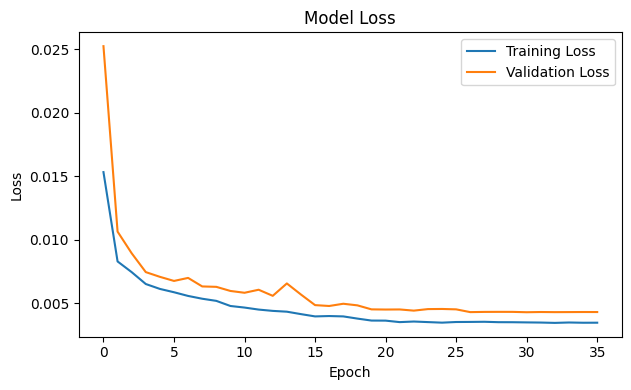

Model kaydedildi: autoencoder_final_20250430-171243.h5


In [6]:
import os
import datetime
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm

# Temiz başlatma
tf.keras.backend.clear_session()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU için bellek büyüme modu etkinleştirildi.")
else:
    print("GPU bulunamadı, CPU kullanılacak.")

print("TensorFlow CUDA destekli mi?:", tf.test.is_built_with_cuda())
print("Fiziksel GPU var mı?:", tf.config.list_physical_devices('GPU'))


def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape, name="input_layer")

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Temporal için 1x1 conv
    x = Conv2D(16, (1, 1), activation='relu')(encoded)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


def load_frames_from_videos(folder, target_size, frame_interval=30):
    frames = []
    valid_ext = ('.mp4', '.avi', '.mkv')

    for root, _, files in os.walk(folder):
        for filename in sorted(files):
            if not filename.lower().endswith(valid_ext):
                continue

            video_path = os.path.join(root, filename)
            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            with tqdm(total=total, desc=f"İşleniyor: {filename}", leave=False) as pbar:
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if frame_idx % frame_interval == 0:
                        frame_resized = cv2.resize(frame, target_size)
                        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                        frames.append(frame_rgb)
                    frame_idx += 1
                    pbar.update(1)
            cap.release()
            tqdm.write(f"{filename}: {frame_idx // frame_interval} kare yüklendi.")

    if not frames:
        raise ValueError(f"'{folder}' klasöründe geçerli video bulunamadı.")

    frames = np.stack(frames, axis=0).astype('float32') / 255.0
    return frames


def train_autoencoder(normal_videos_folder, target_size=(128, 128), batch_size=32, epochs=100):
    print("Normal videolardan frame'ler yükleniyor...")
    frames = load_frames_from_videos(normal_videos_folder, target_size)
    num_samples = frames.shape[0]
    val_count = int(0.1 * num_samples)

    train_frames = frames[val_count:]
    val_frames = frames[:val_count]

    # tf.data pipeline
    train_ds = tf.data.Dataset.from_tensor_slices((train_frames, train_frames)) \
        .shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((val_frames, val_frames)) \
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)

    input_shape = (target_size[1], target_size[0], 3)
    autoencoder = build_autoencoder(input_shape)
    autoencoder.summary()

    # Callbacks
    checkpoint_dir = '/content/sample_data/modelepochsaves'
    os.makedirs(checkpoint_dir, exist_ok=True)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
        ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, 'ae_epoch_{epoch:02d}_val{val_loss:.4f}.h5'),
            monitor='val_loss', save_best_only=True
        )
    ]

    print("Autoencoder eğitimi başlıyor...")
    history = autoencoder.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    return autoencoder, history


# Eğitimi başlat
normal_videos_folder = '/content/sample_data/dataset/Videos/Videos/normal'
autoencoder, history = train_autoencoder(normal_videos_folder)

# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Son modeli kaydet
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
autoencoder.save(f'/content/sample_data/modelepochsaves/autoencoder_final_{timestamp}.h5')
print(f"Model kaydedildi: autoencoder_final_{timestamp}.h5")

In [30]:
import os
import gc
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tqdm import tqdm

# ─── Ayarlar ────────────────────────────────────────────────────────────────
model_path        = '/content/sample_data/modelepochsaves/ae_epoch_27_val0.0043.h5'
video_dir         = '/content/sample_data/dataset/Videos/Videos'
output_csv_path   = 'autoencoder_features_batched2.csv'
target_size       = (128, 128)
frame_interval    = 30
batch_size        = 32

# ─── Modeli yükle ───────────────────────────────────────────────────────────
autoencoder = load_model(
    model_path,
    custom_objects={'mse': MeanSquaredError()}
)
encoder_layer_index = 7
encoder = tf.keras.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.layers[encoder_layer_index].output
)

# ─── Frame akış generator’ü ─────────────────────────────────────────────────
def frame_stream(video_path, target_size, frame_interval):
    cap = cv2.VideoCapture(video_path)
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval == 0:
            f = cv2.resize(frame, target_size)
            f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            yield f.astype('float32') / 255.0
        idx += 1
    cap.release()

# ─── Batch‐batch generator ──────────────────────────────────────────────────
def batch_generator(video_path, target_size, frame_interval, batch_size):
    batch = []
    for frame in frame_stream(video_path, target_size, frame_interval):
        batch.append(frame)
        if len(batch) == batch_size:
            yield np.stack(batch, axis=0)
            batch.clear()
    if batch:
        yield np.stack(batch, axis=0)

# ─── Video dosyalarını topla ────────────────────────────────────────────────
video_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(video_dir)
    for f in files
    if f.lower().endswith(('.mp4', '.avi', '.mov'))
]

print(f"{len(video_files)} video bulundu. İşlem başlıyor...")

# ─── Batch batch işleme ve CSV’ye yazma ─────────────────────────────────────
first_write = True  # CSV başlığını yalnızca bir kez yazmak için

for vid_id, vid_path in enumerate(tqdm(video_files, desc="Videolar işleniyor")):
    for batch in batch_generator(vid_path, target_size, frame_interval, batch_size):
        encoded = encoder.predict(batch, verbose=0)
        recon   = autoencoder.predict(batch, verbose=0)
        errors  = np.mean((batch - recon)**2, axis=(1,2,3))

        if encoded.ndim == 4:
            encoded = encoded.reshape(encoded.shape[0], -1)

        # DataFrame oluştur ve video_path ekle
        df = pd.DataFrame(
            encoded,
            columns=[f'feat_{i}' for i in range(encoded.shape[1])]
        )
        df['recon_error'] = errors
        df['video_id']    = vid_id
        df['video_path']  = vid_path

        # CSV’ye ekle (append modu)
        df.to_csv(
            output_csv_path,
            mode='a',
            header=first_write,
            index=False
        )
        first_write = False

    # Belleği temizle
gc.collect()

print(f"Özellik çıkarımı tamamlandı. Sonuçlar kaydedildi: {output_csv_path}")

3304 video bulundu. İşlem başlıyor...


Videolar işleniyor: 100%|██████████| 3304/3304 [36:44<00:00,  1.50it/s]


Özellik çıkarımı tamamlandı. Sonuçlar kaydedildi: autoencoder_features_batched2.csv


In [31]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,421 (181.34 KB)

 Trainable params: 46,035 (179.82 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

In [32]:
#Augmentation

import torchvision.transforms as T

frame_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-10, 10)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    T.RandomApply([T.GaussianBlur(3)], p=0.3),
    T.RandomApply([T.RandomGrayscale(p=0.2)], p=0.2),
])



In [33]:
import torch

def frame_dropout(frames, p=0.2):
    """Belirli bir ihtimalle rastgele kareleri düşür."""
    keep_mask = torch.rand(len(frames)) > p
    return frames[keep_mask] if keep_mask.sum() > 0 else frames

def speed_perturbation(frames, min_speed=0.8, max_speed=1.2):
    """Videoyu rastgele hızlandır veya yavaşlat."""
    speed_factor = torch.FloatTensor(1).uniform_(min_speed, max_speed).item()
    indices = torch.linspace(0, len(frames)-1, int(len(frames) * speed_factor)).long()
    return frames[indices]

In [34]:
#Fixes frame count after applying frame dropout at augmentation

def fix_frame_count(frames, target_num_frames):
    """Frame sayısını sabitler: Eğer fazla ise kırpar, eksikse tekrarlar."""
    num_frames = frames.shape[0]  # Frame sayısını al

    if num_frames > target_num_frames:
        frames = frames[:target_num_frames]  # Fazla olanları kırp
    elif num_frames < target_num_frames:
        repeat_frames = target_num_frames - num_frames
        last_frame = frames[-1].unsqueeze(0).repeat(repeat_frames, 1, 1, 1)  # Eksik frame'leri tekrar et
        frames = torch.cat([frames, last_frame], dim=0)

    return frames  # Her durumda (T, C, H, W) döner

In [37]:
import os
import random
import torch
from torch.utils.data import Dataset
import torchvision
import torch.nn.functional as F
import pandas as pd

# Yukarıda tanımlı augmentasyon fonksiyonları ve frame_transform kullanılıyor:
# frame_dropout, speed_perturbation, fix_frame_count, frame_transform

class VideoDataset(Dataset):
    def __init__(
        self,
        metadata_df: pd.DataFrame,
        ae_features_csv: str,
        num_frames: int = 8,
        resize_size=(192, 192),
        mode: str = "train"
    ):
        """
        metadata_df: DataFrame with columns ['video_path','binary_label','multi_label']
        ae_features_csv: CSV with ['video_path','recon_error'] per frame index
        """
        self.meta = metadata_df.reset_index(drop=True)
        self.ae_data = pd.read_csv(ae_features_csv)
        self.num_frames = num_frames
        self.resize_size = resize_size
        self.mode = mode

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        video_path = row['video_path']
        binary_label = int(row['binary_label'])
        multi_label = int(row['multi_label'])

        # Segment başlangıcını belirle (AE hatalarına göre)
        vid_err = self.ae_data[self.ae_data['video_path'] == video_path]['recon_error'].values
        total_err = len(vid_err)
        if binary_label == 1:
            # Anormal: sliding window ile en yüksek hata segmentini seç
            if total_err < self.num_frames:
                start_idx = 0
            else:
                means = pd.Series(vid_err).rolling(self.num_frames).mean().dropna().values
                start_idx = int(means.argmax())
        else:
            # Normal: rastgele başlangıç
            if total_err <= self.num_frames:
                start_idx = 0
            else:
                start_idx = random.randint(0, total_err - self.num_frames)

        # Kareleri oku
        frames = []
        vr = torchvision.io.VideoReader(video_path, 'video')
        vr.set_current_stream('video')
        for i, frm in enumerate(vr):
            if i < start_idx:
                continue
            if len(frames) >= self.num_frames:
                break
            img = frm['data'].float() / 255.0  # (C,H,W)
            img = F.interpolate(
                img.unsqueeze(0), size=self.resize_size,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            frames.append(img)
        # Eksikse son kareyi tekrar et
        while len(frames) < self.num_frames:
            frames.append(frames[-1].clone())

        # Augmentasyon (sadece eğitim için)
        clip = torch.stack(frames)  # (T, C, H, W)
        if self.mode == 'train':
            clip = frame_dropout(clip, p=0.2)
            clip = speed_perturbation(clip, min_speed=0.8, max_speed=1.2)
            clip = fix_frame_count(clip, self.num_frames)
            # frame_transform her kareye uygula
            clip = torch.stack([frame_transform(f) for f in clip])

        # Son düzenleme: (C, T, H, W)
        clip = clip.permute(1, 0, 2, 3).contiguous()

        return (
            clip,
            torch.tensor(binary_label, dtype=torch.float32),
            torch.tensor(multi_label, dtype=torch.long)
        )

In [38]:
train_dataset = VideoDataset(train_df, "/content/autoencoder_features_batched2.csv", num_frames=48, mode="train")
test_dataset = VideoDataset(test_df, "/content/autoencoder_features_batched2.csv", num_frames=48, mode="test")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train loader {len(train_loader)} batches")
print(f"Test loader {len(test_loader)} batches")

Train loader 326 batches
Test loader 82 batches


X3D modelimizin output layerini tüm classlarımızı kapsayacak şekilde arttırmamız lazım
Son katman ise ResNetBasicHead altında proj olarak tanımlanmış.

In [16]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 67.6 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=15ae3dccde4a1462afa9cebfdb4757ddc7cfe3255aef175aae5522005f230860
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=15eea6900b5bd459985a4a9dd8106234f150addba7b182b06a91017b27352a81
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel f

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# ✅ X3D Modelini Yükleme
model_name = "x3d_s"
base_model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)

# ✅ **Çıkış Katmanlarını Güncelle**
in_features = base_model.blocks[-1].proj.out_features  # ✅ **Doğru çıkışı al!** (400 olmalı)

binary_head = nn.Linear(2048, 1)  # Binary sınıflandırma için Sigmoid
multi_head = nn.Linear(2048, len(train_df["multi_label"].unique()))  # Multi-class sınıflandırma

# ✅ **MultiTaskX3D Modeli**
class MultiTaskX3D(nn.Module):
    def __init__(self, base_model, binary_head, multi_head):
        super(MultiTaskX3D, self).__init__()

        # **Feature Extractor - Son bloğun içindeki ProjectedPool eklendi!**
        self.feature_extractor = nn.Sequential(
            *base_model.blocks[:-1],
            base_model.blocks[-1].pool  # ✅ **Burada 400'e dönüşüm sağlandı!**
        )

        # **Global Average Pooling - Tüm boyutları 1x1x1'e düşürüyor!**
        self.gap = nn.AdaptiveAvgPool3d(1)

        # **Flatten**
        self.flatten = nn.Flatten()

        # **Çıkış Katmanları**
        self.binary_head = binary_head
        self.binary_activation = nn.Sigmoid()

        self.multi_head = multi_head
        self.multi_activation = nn.Softmax(dim=1)

    def forward(self, x):
        #print(f"🚀 Model Girişi: {x.shape}")

        x = self.feature_extractor(x)
        #print(f"🟡 Feature Extractor Çıkışı: {x.shape}")  # **(16, 400, 1, 1, 1) olmalı!**

        x = self.gap(x)  # ✅ **GAP ile (16, 400, 1, 1, 1)**
        #print(f"🔵 GAP Sonrası Boyut: {x.shape}")

        x = self.flatten(x)  # ✅ **Artık (16, 400) olması lazım!**
        #print(f"🟢 Flatten Sonrası Boyut: {x.shape}")

        binary_out = self.binary_head(x)  # Binary sınıflandırma
        multi_out = self.multi_activation(self.multi_head(x))  # Multi-class sınıflandırma

        return binary_out, multi_out

# ✅ Modeli başlat
model = MultiTaskX3D(base_model, binary_head, multi_head)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"🚀 Model başarıyla yüklendi! Çalıştırılan cihaz: {device}")

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


🚀 Model başarıyla yüklendi! Çalıştırılan cihaz: cuda


import torch

model = model.to("cpu")
dummy_input = torch.randn(1, 3, 16, 160, 160)

torch.onnx.export(model, dummy_input, "x3d_xs.onnx", opset_version=11
                  ,do_constant_folding=True, input_names=["input"], output_names=["output"])

In [40]:
from torch.nn import CrossEntropyLoss

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self,inputs,targets):
        ce_loss = F.cross_entropy(inputs,targets,reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

epoch_file_location = "/content/sample_data/modelepochsavesx3d"

# 🎯 Loss & Optimizer
criterion_binary = nn.BCEWithLogitsLoss()  # Binary classification için
criterion_multi = FocalLoss()  # Multi-class classification için

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)  # Weight decay ile overfitting azaltılır
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ⚡ AMP (Automatic Mixed Precision)
scaler = torch.amp.GradScaler()

# 🛑 Early Stopping Parametreleri
patience = 3  # Kaç epoch boyunca iyileşme olmazsa durdursun
min_delta = 0.01  # İyileşme için gereken minimum fark
best_loss = float("inf")  # En iyi validation loss başta sonsuz olarak ayarlanır
counter = 0  # İyileşme olmayan epoch sayısı
accuracy_threshold = 85.0  # Accuracy'nin geçmesi gereken eşik

device = "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(40):
    model.train()
    running_loss = 0.0

    for videos, binary_labels, multi_labels in train_loader:
        videos, binary_labels, multi_labels = (
            videos.to(device),
            binary_labels.to(device).float(),
            multi_labels.to(device),
        )

        optimizer.zero_grad()

        with torch.amp.autocast(device):
            binary_out, multi_out = model(videos)

            # 🟢 Binary Classification Loss (Sigmoid)
            binary_loss = criterion_binary(binary_out.squeeze(), binary_labels)

            # 🔴 Multi-Class Classification Loss (Softmax) → Sadece anormal olanlara uygula
            mask = (binary_labels == 1)
            if mask.sum() > 0:
                multi_loss = criterion_multi(multi_out[mask], multi_labels[mask])
            else:
                multi_loss = torch.tensor(0.0, device=device)

            # ✅ Toplam loss hesapla (Binary + Multi)
            total_loss = binary_loss + multi_loss

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += total_loss.item()

    train_loss = running_loss / len(train_loader)

    # 📌 VALIDATION AŞAMASI
    model.eval()
    val_loss = 0.0
    correct_binary = 0
    correct_multi = 0
    total_binary = 0
    total_multi = 0

    with torch.no_grad():
        for videos, binary_labels, multi_labels in test_loader:
            videos, binary_labels, multi_labels = (
                videos.to(device),
                binary_labels.to(device).float(),
                multi_labels.to(device),
            )

            binary_out, multi_out = model(videos)

            # ✅ Binary Accuracy (Normal mi, Anormal mi?)
            pred_binary = (binary_out.squeeze() > 0.5).long()
            correct_binary += (pred_binary == binary_labels).sum().item()
            total_binary += binary_labels.size(0)

            # ✅ Multi-Class Accuracy (Eğer anormalse hangi sınıf?)
            mask = (binary_labels == 1)
            if mask.sum() > 0:
                pred_multi = torch.argmax(multi_out[mask], dim=1)
                correct_multi += (pred_multi == multi_labels[mask]).sum().item()
                total_multi += multi_labels[mask].size(0)

            # ✅ Validation loss hesapla
            loss = criterion_binary(binary_out.squeeze(), binary_labels)
            if total_multi > 0:
                loss += criterion_multi(multi_out[mask], multi_labels[mask])
            val_loss += loss.item()

    val_loss /= len(test_loader)
    binary_acc = 100 * correct_binary / total_binary
    multi_acc = 100 * correct_multi / total_multi if total_multi > 0 else 0

    print(
        f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
        f"| Binary Acc: {binary_acc:.2f}% | Multi Acc: {multi_acc:.2f}%"
    )

    # ✅ **Early Stopping (Binary Accuracy 85%'i geçmeli)**
    if binary_acc >= accuracy_threshold:
        if best_loss - val_loss > min_delta:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f"{epoch_file_location}/best_model_epoch_{epoch+1}.pth")
            print(f"✅ Model kaydedildi: best_model_epoch_{epoch+1}.pth")
        else:
            counter += 1
            print(f"❗ Early stopping counter: {counter}/{patience}")

        if counter >= patience:
            print("⏹️ Early stopping triggered. Training stopped.")
            break
    else:
        print(f"🚨 Accuracy {binary_acc:.2f}% < {accuracy_threshold}%, early stopping devre dışı!")

    scheduler.step()

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{epoch_file_location}/checkpoint_{epoch}.pth",
        )
        print(f"Model {epoch + 1} saved to checkpoint_{epoch + 1}.pth")

print("✅ Eğitim tamamlandı!")

KeyboardInterrupt: 